In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
import pandas as pd

cols = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland"
]

def repair_row(tokens: list[str]) -> list[str] | None:
    """
    tokens is the raw list of strings that made pandas complain.
    Return:
        • list of exactly 8 strings  → pandas keeps the row
        • None                       → pandas skips the row
    """
    if len(tokens) < 8:                      
        return None

    fixed      = tokens[:6]
    bundesland = tokens[-1]                  
    name       = " ".join(tokens[6:-1])      
    return fixed + [name, bundesland] 



df = pd.read_csv(
    "zehn_min_rr_Beschreibung_Stationen.txt",
    sep=r"\s+",     # tab OR ≥2 spaces  → keeps single blanks inside names
    skiprows=2,              
    names=cols,              
    engine="python",         
    encoding="cp1252",       
    keep_default_na=False,   
    on_bad_lines=repair_row  
)


df["Stations_id"]   = df["Stations_id"].astype(int)
df["von_datum"]     = pd.to_datetime(df["von_datum"], format="%Y%m%d")
df["bis_datum"]     = pd.to_datetime(df["bis_datum"], format="%Y%m%d")
df["Stationshoehe"] = pd.to_numeric(df["Stationshoehe"])
df["geoBreite"]     = pd.to_numeric(df["geoBreite"])
df["geoLaenge"]     = pd.to_numeric(df["geoLaenge"])

len(df)

1068

In [25]:
main_df = df
main_df

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,20,2004-08-12,2024-04-22,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
1,44,2007-02-08,2024-04-22,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,53,2005-08-31,2024-04-22,60,52.5850,13.5634,Ahrensfelde,Brandenburg
3,73,2007-02-13,2024-04-22,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern
4,78,2004-10-10,2024-04-22,64,52.4853,7.9125,Alfhausen,Niedersachsen
...,...,...,...,...,...,...,...,...
1063,19172,2020-08-20,2024-04-22,48,54.0246,9.3880,Wacken,Schleswig-Holstein
1064,19207,2023-03-30,2024-04-22,16,53.8178,12.0645,Gülzow-Prüzen,Mecklenburg-Vorpommern
1065,19299,2021-03-22,2024-04-22,463,49.8713,11.7883,Speichersdorf,Bayern
1066,19897,2023-12-31,2024-04-22,37,52.5040,13.4550,Berlin-Friedrichshain-Nord,Berlin


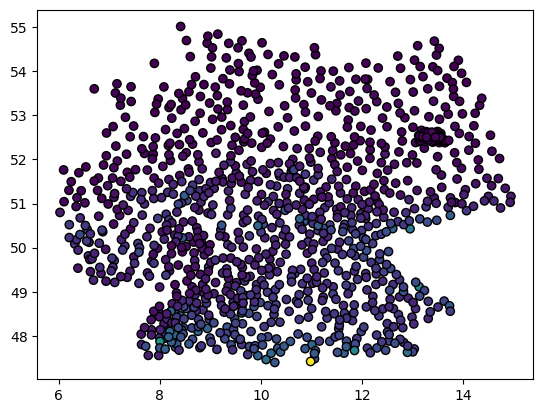

In [26]:
plt.scatter(df['geoLaenge'],df['geoBreite'], c= df["Stationshoehe"],  cmap="viridis", edgecolor="k")

In [52]:
df_10m = pd.read_csv('10min_processed.csv')
df_10m['date'] = pd.to_datetime(df_10m['date'] , format="%Y%m%d%H%M")
df_10m = df_10m[df_10m['rain'] != -999 ]

df_10m

,stationid,date,rain
0,6303,2024-04-20 00:00:00,0.0
1,6303,2024-04-20 00:10:00,0.0
2,6303,2024-04-20 00:20:00,0.0
3,6303,2024-04-20 00:30:00,0.0
4,6303,2024-04-20 00:40:00,0.0
...,...,...,...
150986,7429,2024-04-20 23:10:00,0.0
150987,7429,2024-04-20 23:20:00,0.0
150988,7429,2024-04-20 23:30:00,0.0
150989,7429,2024-04-20 23:40:00,0.0


In [53]:
stations = df_10m.stationid.unique()
print(stations)
dfs = {station : df_10m.loc[df_10m.stationid == station ].resample('h',on='date').sum() for station in stations}


[6303 3081 7369 ... 1278 1650 7429]


1049


In [59]:
df_10m_agg = pd.concat(dfs).reset_index().drop('level_0', axis =1)
df_10m_agg

,date,stationid,rain
0,2024-04-20 00:00:00,37818,0.0
1,2024-04-20 01:00:00,37818,0.0
2,2024-04-20 02:00:00,37818,0.0
3,2024-04-20 03:00:00,37818,0.0
4,2024-04-20 04:00:00,37818,0.0
...,...,...,...
25117,2024-04-20 19:00:00,44574,0.0
25118,2024-04-20 20:00:00,44574,0.0
25119,2024-04-20 21:00:00,44574,0.0
25120,2024-04-20 22:00:00,44574,0.0
